
<div style="text-align: center;">
  <img width="420" height="420" src="https://www.naterscreations.com/imputegap/logo_imputegab.png" />
</div>

<h1>ImputeGAP: Advanced Analytics Notebook</h1>

ImputeGAP is a complete end-to-end imputation library that supports the entire workflow —from data collection to interpreting imputation results and assessing their impact. It features two interconnected components: the imputation pipeline and the advanced analysis module. These can be used together via a standardized configuration-driven pipeline or independently through manual instantiation. The documentation is available on: https://imputegap.readthedocs.io/

This notebook demonstrates components of the explore unit, including benchmarking, downstream evaluation, and the explainer.
Before proceeding, please ensure the library and required Jupyter dependencies are installed:

In [ ]:
%pip install imputegap==1.1.2

In [ ]:
%pip install -U ipywidgets

<h1>Benchmark</h1>

ImputeGAP can serve as a common test-bed for comparing the effectiveness and efficiency of time series imputation algorithms. Users have full control over the benchmark by customizing various parameters, including the list of the algorithms to compare, the optimizer, the datasets to evaluate, the missingness patterns, the range of missing values, and the performance metrics.

The benchmarking module can be utilized as follows:

In [8]:
from imputegap.recovery.benchmark import Benchmark
from imputegap.tools import utils

my_algorithms = ["MeanImpute", "SoftImpute"]

my_opt = "default_params"

my_datasets = ["eeg-alcohol"]

my_patterns = ["mcar"]

range = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

# launch the evaluation
bench = Benchmark()
bench.eval(algorithms=my_algorithms, datasets=my_datasets, patterns=my_patterns, x_axis=range, optimizer=my_opt)


The benchmark has been called:
	algorithms: ['MeanImpute', 'SoftImpute']
	datasets: ['eeg-alcohol']
	patterns: ['mcar']
	missing_percentages: [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
	optimizer: default_params
	normalizer: z_score
	runs: 1
	number max series: 200
	number max values: 2000


MeanImpute is tested with mcar on eeg-alcohol, started at 2026-01-22 15:44:27.
done!


SoftImpute is tested with mcar on eeg-alcohol, started at 2026-01-22 15:44:34.
done!



> logs: benchmark - Execution Time: 19.1313 seconds


eegalcohol: {mcar, RMSE, default_params}

 Rate       MeanImpute          SoftImpute     

 0.05      0.9945302343        0.5022733403    
  0.1      0.8081365539        0.3797954812    
  0.2      0.9727791074        0.4246409227    
  0.4      0.9879033826        0.4334707248    
  0.6      0.9900236459        0.4469672608    
  0.8      0.9947606840        0.4811537021    



eegalcohol: {mcar, RUNTIME[ms], default_params}

 Rate       MeanImpute          SoftImpute     

 0.05   

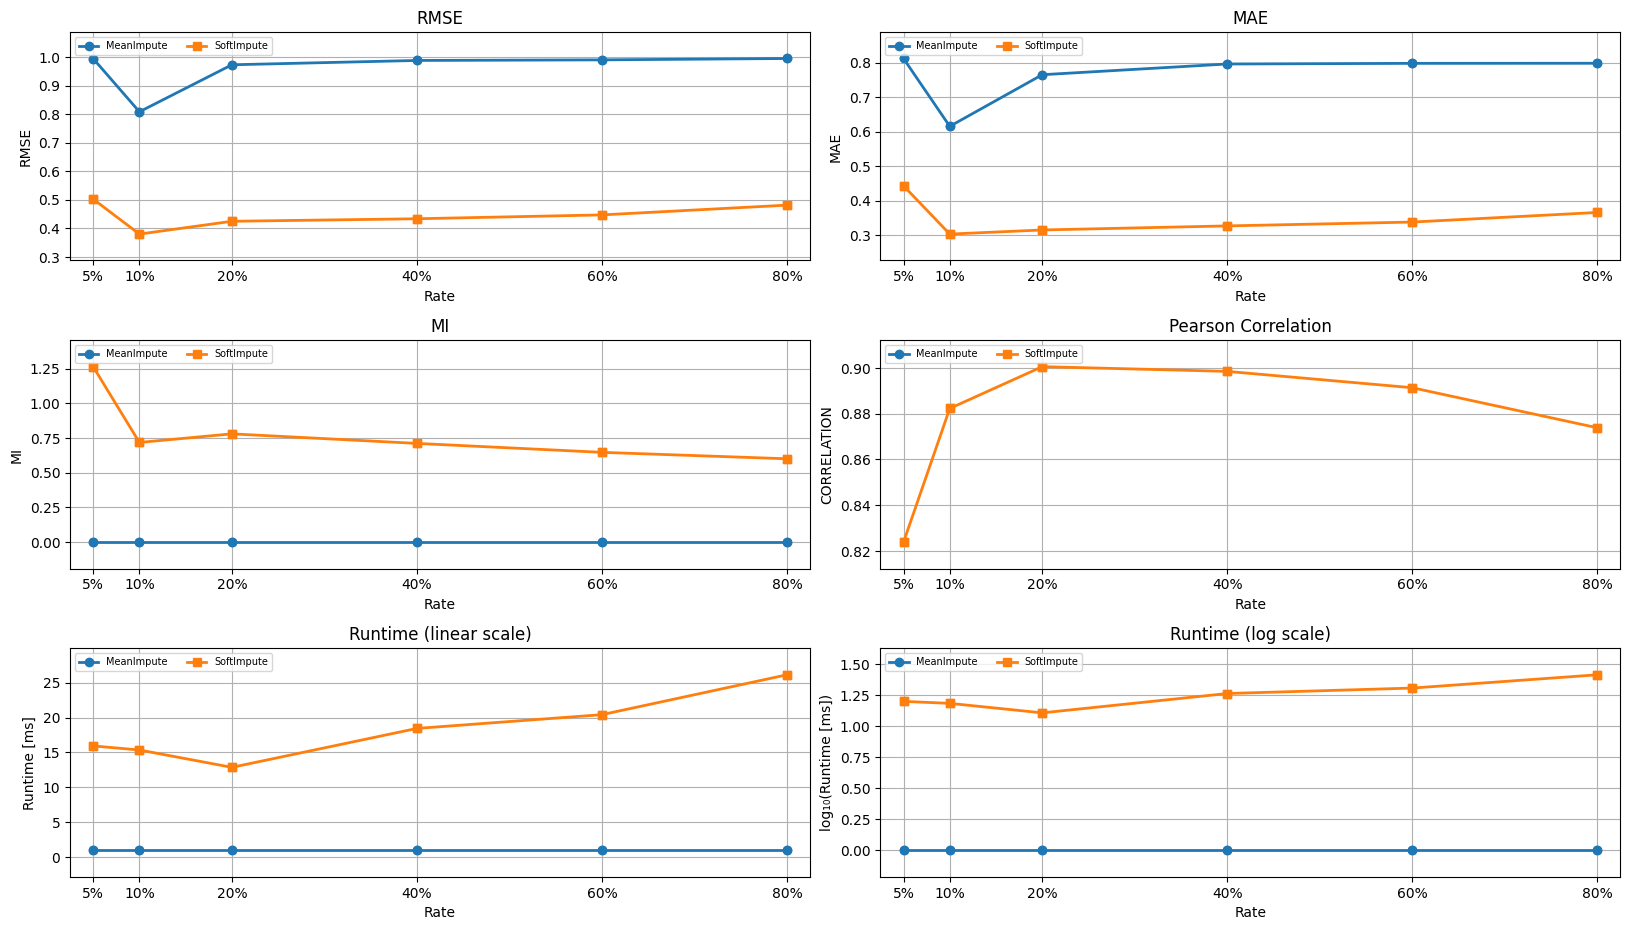

In [12]:
# display the plot
%matplotlib inline
bench.subplots.show()

You can enable the optimizer using the following command:

In [11]:
opt = {"optimizer": "ray_tune", "options": {"n_calls": 1, "max_concurrent_trials": 1}}
my_opt = [opt]

<br>

<h1>Downstream</h1>

ImputeGAP includes a dedicated module for systematically evaluating the impact of data imputation on downstream tasks. Currently, forecasting is the primary supported task, with plans to expand to additional tasks in the future.

In [13]:
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.contamination import GenGap
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()
print(f"\nImputeGAP downstream models for forcasting : {ts.forecasting_models}")

# load and normalize the dataset
ts.load_series(utils.search_path("forecast-economy"), normalizer="z_score")

# contaminate the time series
ts_m = GenGap.aligned(ts.data, rate_series=0.7)

# define and impute the contaminated series
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()

# compute and print the downstream results
downstream_config = {"task": "forecast", "model": "prophet", "baseline": "ZeroImpute", "split": 0.8}
imputer.score(ts.data, imputer.recov_data, downstream=downstream_config)
ts.print_results(imputer.downstream_metrics, text="Downstream results")


ImputeGAP Library has been invoked (https://github.com/eXascaleInfolab/ImputeGAP)


ImputeGAP downstream models for forcasting : ['arima', 'croston', 'deepar', 'ets', 'exp-smoothing', 'hw-add', 'lightgbm', 'lstm', 'naive', 'nbeats', 'prophet', 'sf-arima', 'theta', 'transformer', 'unobs', 'xgboost']

(SYS) The dataset is loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/datasets/forecast-economy.txt

> logs: normalization (z_score) of the data - runtime: 0.0005 seconds

(CONT) missigness pattern: ALIGNED
	percentage of contaminated series: 20.0%
	rate of missing data per series: 70.0%
	security offset: [0-94]
	timestamps impacted : 94 -> 744
	series impacted : 0 -> 3


(IMPUTATION) CDRec
	Matrix: 931, 16
	truncation rank: 3
	epsilon: 1e-06
	iterations: 100

call: cdrec.impute(params={'rank': 3, 'epsilon': 1e-06, 'iterations': 100})

> logs: imputation cdrec - Execution Time: 1.8851 seconds.


(DOWNSTREAM) Default parameters of the downstream model loaded.


15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing


plots saved in:  /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/imputegap_assets/downstream

Downstream results :
MSE_original         = 0.9068209167491901
MSE_cdrec            = 0.9086036902520218
MSE_zeroimpute       = 0.9367010057574212
sMAPE_original       = 193.3773675181798
sMAPE_cdrec          = 193.52210241476573
sMAPE_zeroimpute     = 197.54965786640582


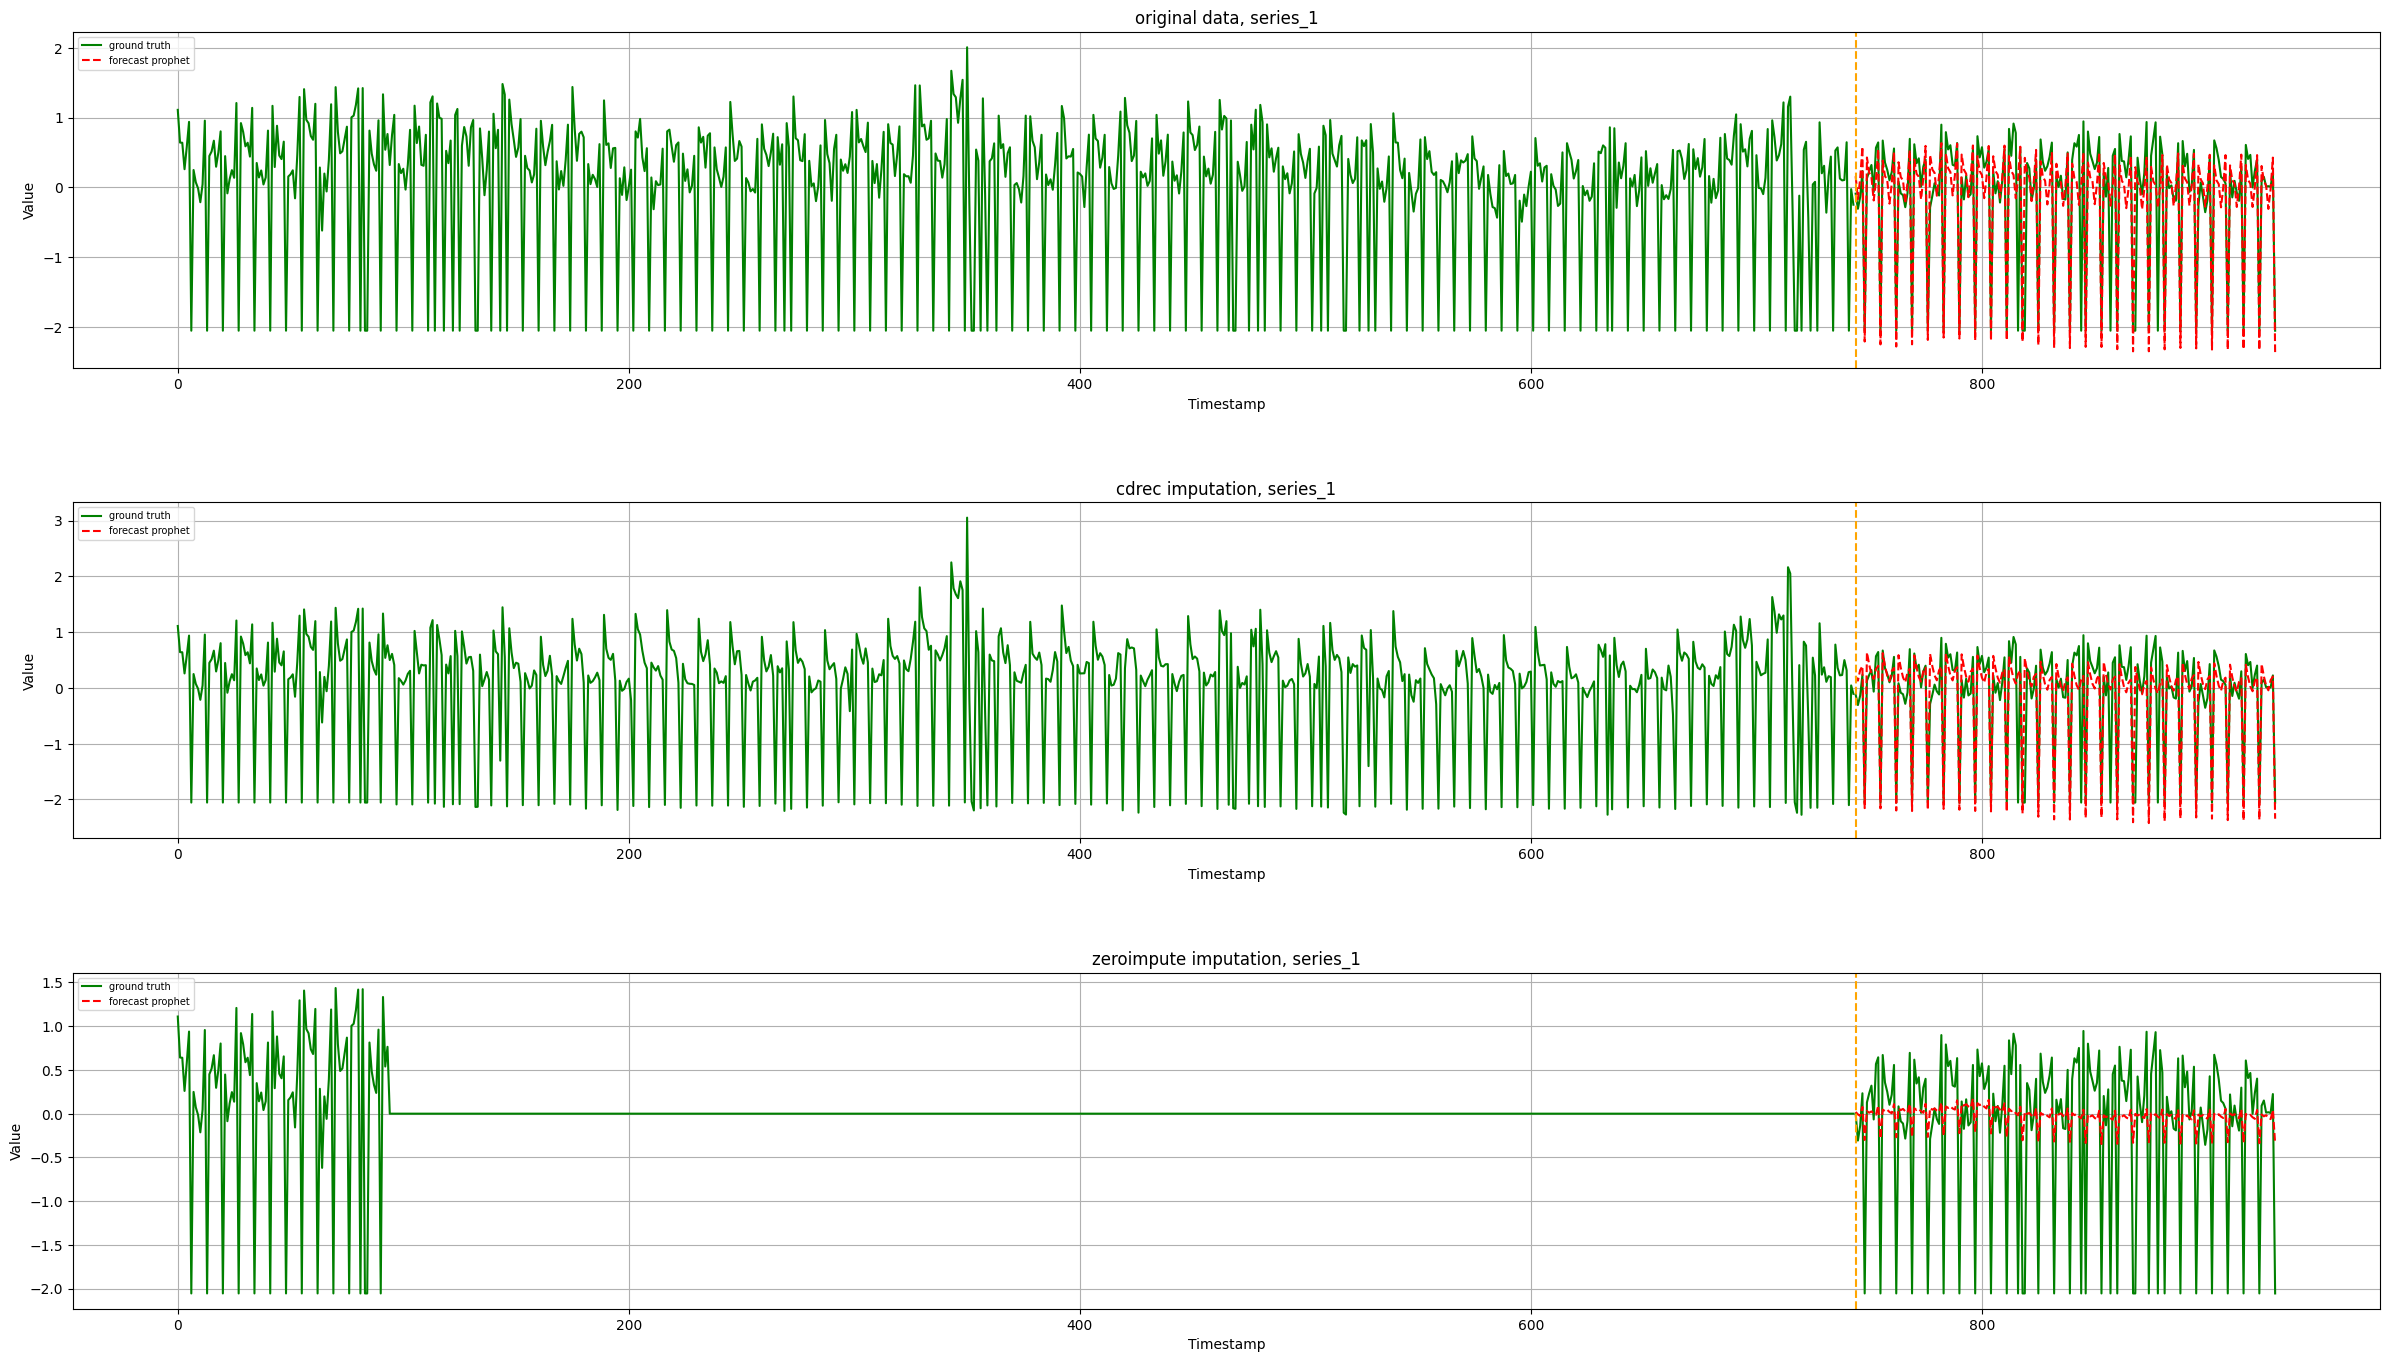

In [14]:
%matplotlib inline
imputer.downstream_plot.show()

<br>

All downstream models develboped in ImputeGAP are available in the ``ts.forecasting_models`` module, which can be listed as follows:

In [15]:
ts.forecasting_models

['arima',
 'croston',
 'deepar',
 'ets',
 'exp-smoothing',
 'hw-add',
 'lightgbm',
 'lstm',
 'naive',
 'nbeats',
 'prophet',
 'sf-arima',
 'theta',
 'transformer',
 'unobs',
 'xgboost']

<br>

<h1>Explainer</h1>

The library provides insights into the algorithm’s behavior by identifying the features that impact the imputation results. It trains a regression model to predict imputation results across various methods and uses SHapley Additive exPlanations (SHAP) to reveal how different time series features influence the model’s predictions.

Let’s illustrate the explainer using the CDRec algorithm and MCAR missingness pattern:

In [16]:
from imputegap.recovery.manager import TimeSeries
from imputegap.recovery.explainer import Explainer
from imputegap.tools import utils

# initialize the time series and explainer object
ts = TimeSeries()
exp = Explainer()
print(f"\nImputeGAP explainer features extractor : {ts.extractors}")

# load and normalize the dataset
ts.load_series(utils.search_path("eeg-alcohol"), normalizer="z_score")

# configure the explanation
exp.shap_explainer(input_data=ts.data, extractor="pycatch", pattern="mcar", file_name=ts.name, algorithm="CDRec")

# print the impact of each feature
exp.print(exp.shap_values, exp.shap_details)



ImputeGAP Library has been invoked (https://github.com/eXascaleInfolab/ImputeGAP)


ImputeGAP explainer features extractor : ['pycatch', 'tsfel', 'tsfresh']

(SYS) The dataset is loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/datasets/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0003 seconds

explainer launched
	extractor: pycatch 
	imputation algorithm: CDRec 
	params: None 
	missigness pattern: mcar
	missing rate: 40.0%
	nbr of series training set: 38
	nbr of series testing set: 26


Generation  0 / 64 ( 0 %)________________________________________________________
	Contamination  0 ...
feature_name = 'DN_HistogramMode_5' (0/22) : feature_value = -0.2651558150368687
feature_name = 'DN_HistogramMode_10' (1/22) : feature_value = 0.12240744588553376
feature_name = 'CO_f1ecac' (2/22) : feature_value = 4.862960206673732
feature_name = 'CO_FirstMin_ac' (3/22) : feature_value = 1
feature_name = 'CO_HistogramAMI_even_2_5' (4/22) :

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

/mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/recovery/explainer.py:528: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shval, x_test, plot_size=(25, 10), feature_names=optimal_display, show=display)
/mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/recovery/explainer.py:547: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(np.array(shval).T, np.array(x_test).T, feature_names=series_names, show=display)
/mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/recovery/explainer.py:611: FutureWarning: The NumPy global RNG was seeded by calling `np.rand



	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_all.png


	plot has been saved :  ./imputegap_assets/shap/analysis_grouped/eeg-alcohol_CDRec_pycatch_DTL_Waterfall.png


	plot has been saved :  ./imputegap_assets/shap/analysis_grouped/eeg-alcohol_CDRec_pycatch_shap_reverse.png


	plot has been saved :  ./imputegap_assets/shap/analysis_grouped/eeg-alcohol_CDRec_pycatch_DTL_Beeswarm.png


	plot has been saved :  ./imputegap_assets/shap/analysis_per_cat/eeg-alcohol_CDRec_pycatch_shap_geometry.png


	plot has been saved :  ./imputegap_assets/shap/analysis_per_cat/eeg-alcohol_CDRec_pycatch_shap_transformation.png


	plot has been saved :  ./imputegap_assets/shap/analysis_per_cat/eeg-alcohol_CDRec_pycatch_shap_correlation.png


	plot has been saved :  ./imputegap_assets/shap/analysis_per_cat/eeg-alcohol_CDRec_pycatch_shap_trend.png


	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_cat.png


	plot has been saved :  ./imputegap_ass

/mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/recovery/explainer.py:74: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shval, x_test, plot_size=(25, 10), feature_names=optimal_display)


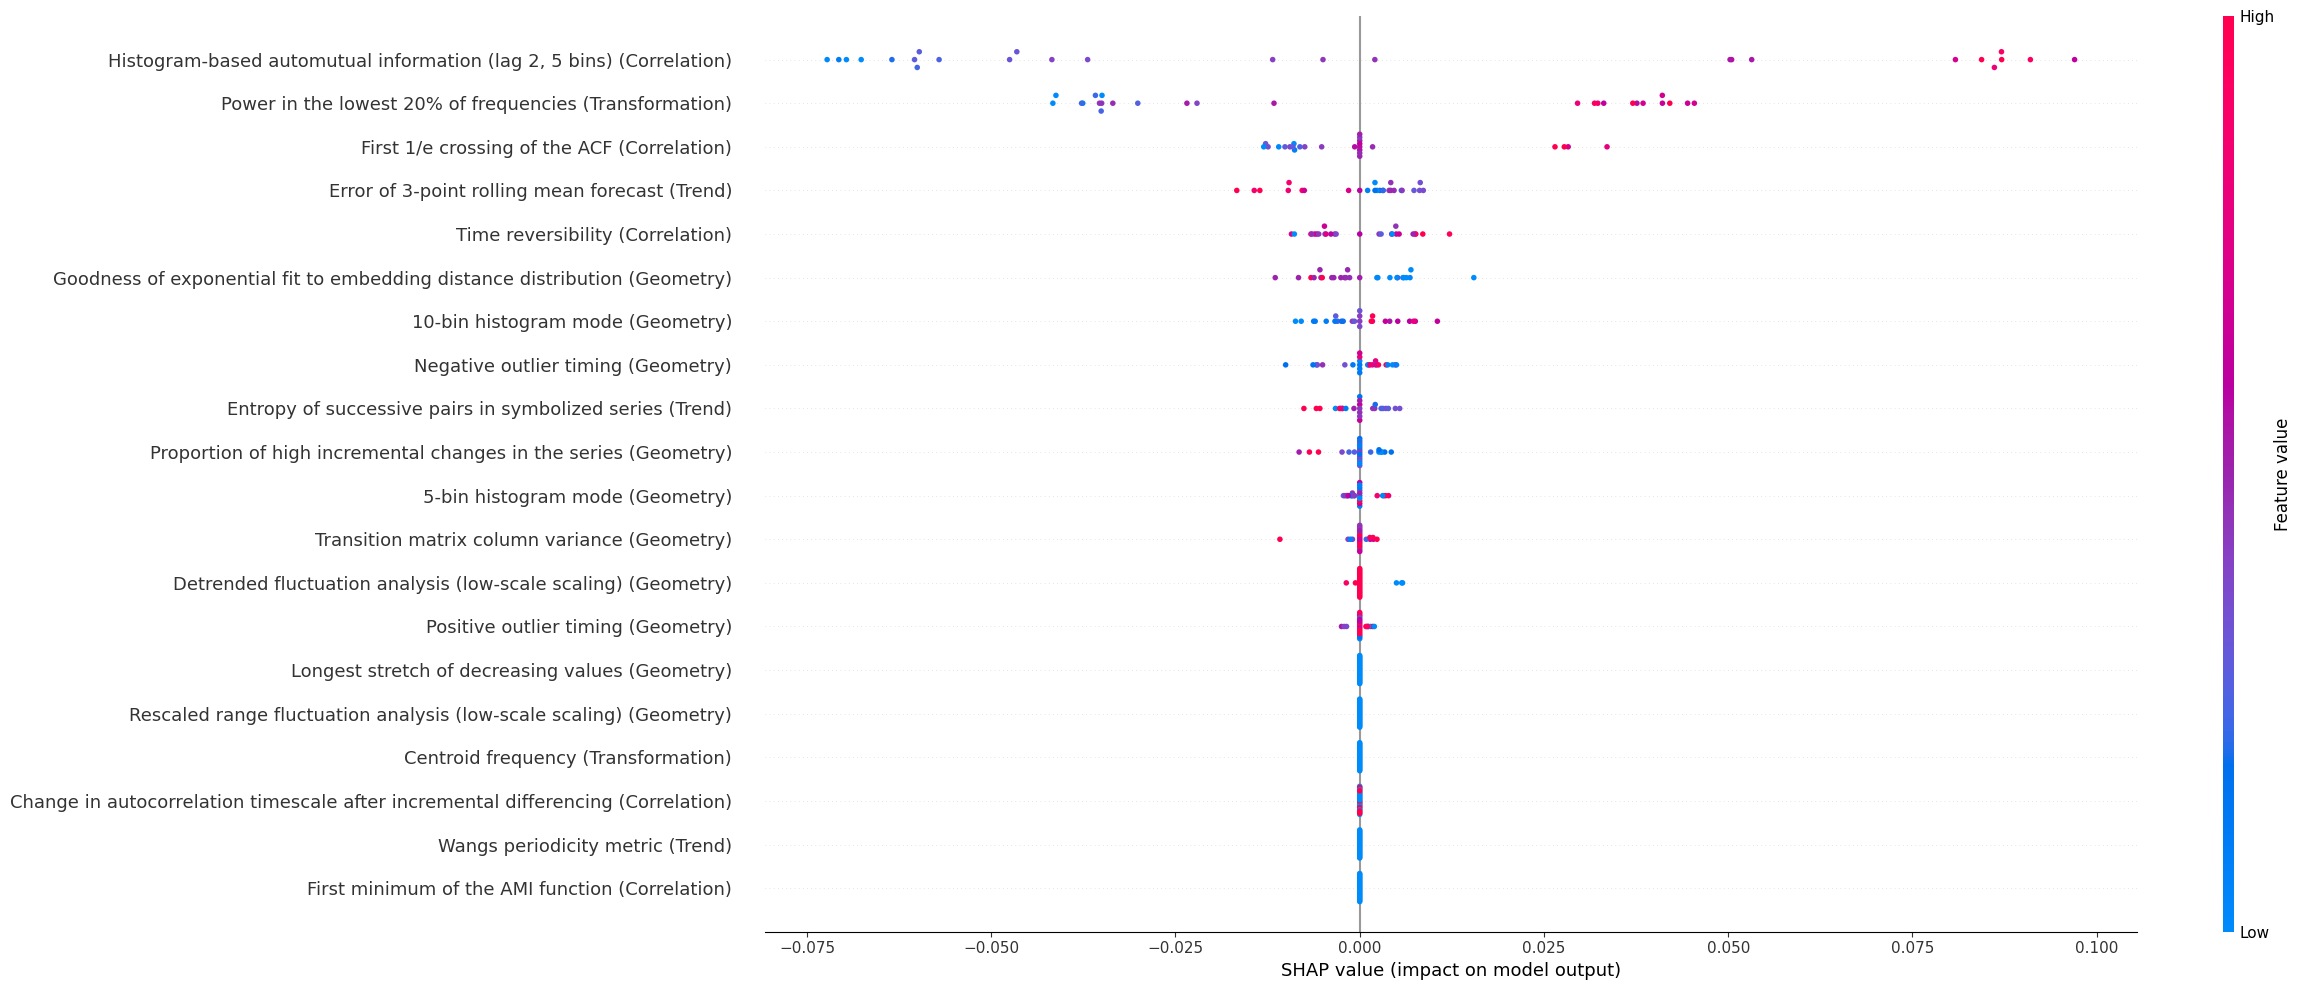

In [19]:
%matplotlib inline
# plot the feature impacts
exp.show()

<br>

All feature extractors developed in ImputeGAP are available in the ``ts.extractors`` module. They can be listed as follows:

In [18]:
ts.extractors

['pycatch', 'tsfel', 'tsfresh']